In [1]:
pip install transformers==4.26.1 datasets evaluate


[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset

/home/ray/anaconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
food = load_dataset("food101", split="train[:5000]")

Found cached dataset food101 (/home/jovyan/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


In [4]:
food = food.train_test_split(test_size=0.2)

In [5]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 20}

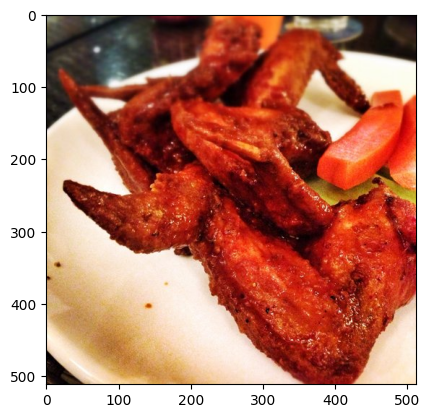

'chicken_wings'

In [16]:
import matplotlib.pyplot as plt
import numpy as np
img_array = np.array(food["train"][0]['image'])
plt.imshow(img_array)
plt.show()
labels[food["train"][0]['label']]

In [6]:
labels = food["train"].features["label"].names

In [7]:
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [9]:
id2label[str(79)]

'prime_rib'

In [10]:
from transformers import AutoImageProcessor

In [13]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [17]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [18]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [19]:
food = food.with_transform(transforms)

In [23]:
img_array = np.array(food["train"][0]['pixel_values'])
print(img_array)

[[[-0.52156866 -0.54509807 -0.6        ... -0.8509804  -0.8352941
   -0.81960785]
  [-0.56078434 -0.6        -0.6627451  ... -0.8509804  -0.8352941
   -0.8117647 ]
  [-0.62352943 -0.6784314  -0.7411765  ... -0.8352941  -0.827451
   -0.8117647 ]
  ...
  [ 0.6392157   0.60784316  0.6        ...  0.3411765   0.4666667
    0.73333335]
  [ 0.654902    0.5921569   0.5921569  ...  0.2941177   0.7176471
    0.88235295]
  [ 0.654902    0.62352943  0.62352943 ...  0.54509807  0.8039216
    0.827451  ]]

 [[-0.60784316 -0.6392157  -0.6784314  ... -0.8666667  -0.8509804
   -0.8352941 ]
  [-0.6392157  -0.67058825 -0.70980394 ... -0.8666667  -0.8509804
   -0.8352941 ]
  [-0.6784314  -0.7176471  -0.77254903 ... -0.8666667  -0.8509804
   -0.84313726]
  ...
  [ 0.30980396  0.26274514  0.24705887 ... -0.5372549  -0.29411763
    0.07450986]
  [ 0.33333337  0.26274514  0.254902   ... -0.46666664  0.14509809
    0.45882356]
  [ 0.33333337  0.30980396  0.30196083 ... -0.08235294  0.36470592
    0.5372549 ]]

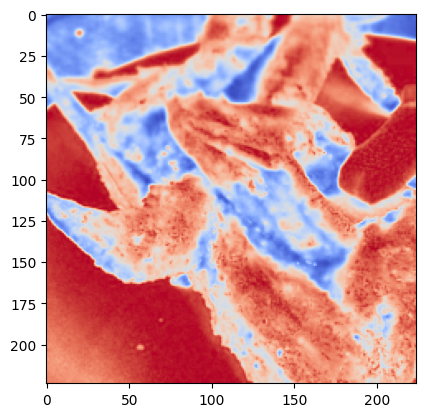

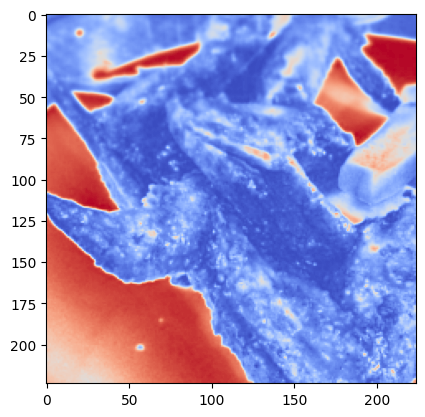

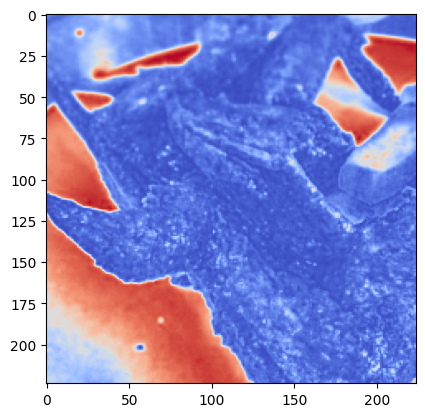

In [27]:
plt.imshow(img_array[0], cmap='coolwarm')
plt.show()
plt.imshow(img_array[1], cmap='coolwarm')
plt.show()
plt.imshow(img_array[2], cmap='coolwarm')
plt.show()

In [28]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [30]:
accuracy = evaluate.load("accuracy")

In [31]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [32]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [37]:
trainer.train()

/home/ray/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 4
  Total optimization steps = 63
  Number of trainable parameters = 85876325
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,3.904100,3.562867,0.660000
2,3.136200,3.005734,0.783000
3,2.836800,2.831869,0.801000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 48
Saving model checkpoint to my_awesome_food_model/checkpoint-21
Configuration saved in my_awesome_food_model/checkpoint-21/config.json
Model weights saved in my_awesome_food_model/checkpoint-21/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-21/preprocessor_config.json
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 48
Saving model checkpoint to my_awesome_food_model/checkpoint-42
Configuration saved in my_awesome_food_model/checkpoint-42/config.json
Model weights saved in my_awesome_food_model/checkpoint-42/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-42/preproc

TrainOutput(global_step=63, training_loss=3.432209983704582, metrics={'train_runtime': 162.3615, 'train_samples_per_second': 73.909, 'train_steps_per_second': 0.388, 'total_flos': 9.307289843712e+17, 'train_loss': 3.432209983704582, 'epoch': 3.0})

In [39]:
gpu_model = model.to('cuda')

In [40]:
gpu_trainer = Trainer(
    model=gpu_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [41]:
gpu_trainer.train()

/home/ray/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 4
  Total optimization steps = 63
  Number of trainable parameters = 85876325
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,2.423500,2.302125,0.809000
2,2.041700,2.005737,0.837000
3,1.882100,1.918434,0.861000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 48
Saving model checkpoint to my_awesome_food_model/checkpoint-21
Configuration saved in my_awesome_food_model/checkpoint-21/config.json
Model weights saved in my_awesome_food_model/checkpoint-21/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-21/preprocessor_config.json
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 48
Saving model checkpoint to my_awesome_food_model/checkpoint-42
Configuration saved in my_awesome_food_model/checkpoint-42/config.json
Model weights saved in my_awesome_food_model/checkpoint-42/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-42/preproc

TrainOutput(global_step=63, training_loss=2.1897841029696994, metrics={'train_runtime': 153.7935, 'train_samples_per_second': 78.027, 'train_steps_per_second': 0.41, 'total_flos': 9.307289843712e+17, 'train_loss': 2.1897841029696994, 'epoch': 3.0})

In [42]:
from transformers import pipeline

In [47]:
ds = load_dataset("food101", split="validation[:10]")

image = ds["image"][0]


Found cached dataset food101 (/home/jovyan/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


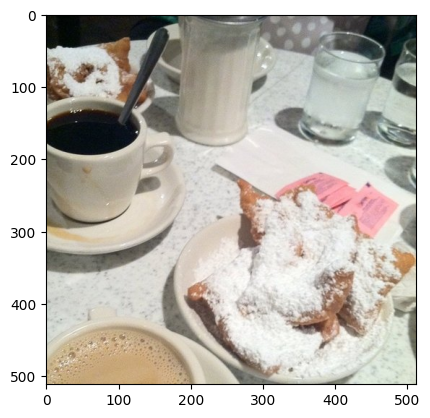

In [48]:
plt.imshow(image)

In [50]:
classifier = pipeline("image-classification", model="./my_awesome_food_model/checkpoint-63")

loading configuration file ./my_awesome_food_model/checkpoint-63/config.json
Model config ViTConfig {
  "_name_or_path": "./my_awesome_food_model/checkpoint-63",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder"

In [51]:
classifier(image)

[{'score': 0.22899200022220612, 'label': 'beignets'},
 {'score': 0.0191508699208498, 'label': 'bruschetta'},
 {'score': 0.013098681345582008, 'label': 'ramen'},
 {'score': 0.012957974337041378, 'label': 'chicken_wings'},
 {'score': 0.01164062600582838, 'label': 'prime_rib'}]